# 連続空間での最適化

ここまでのチュートリアルでは、特徴量空間を離散化してベイズ最適化を実行してきました。
PHYSBOは連続量のまま最適化することもできます。

連続空間で獲得関数を最大化するためのアルゴリズムとして、ランダムサーチが実装されています。
また、最適化ライブラリとして、[ODAT-SE](https://github.com/issp-center-dev/ODAT-SE)を使用することもできます。
これは `pip` を用いてインストール可能です。

``` bash
python3 -m pip install odatse
```

## 基本的な使い方

まずは必要なモジュールをインポートします。

In [1]:
import numpy as np
import physbo
import matplotlib.pyplot as plt

最適化したい関数 `simulator` について、離散版では候補点の番号 `action` を入力として受け取りましたが、連続版では座標 `x` を直接入力として受け取ります。
`x` は $N\times D$ の配列で、$N$ は計算するデータの数、$D$ は特徴量の次元数です。

In [2]:
def simulator(x):
    return -np.sum(x**2, axis=1)

特徴量空間の下限と上限をそれぞれ `min_X` と `max_X` で指定します。

In [3]:
min_X = [-2.0, -2.0]
max_X = [2.0, 2.0]

連続空間版の `Policy` クラスは `physbo.search.range.Policy` です。
コンストラクタには `min_X` と `max_X` を指定します。
また、離散空間版と同様に `mpi4py.MPI.Comm` を `comm` として渡すことで並列実行が可能です。
`set_seed` メソッドを用いて乱数のシードを設定することもできます。

In [4]:
seed = 31415
policy = physbo.search.range.Policy(min_X=min_X, max_X=max_X)
policy.set_seed(seed)

一度 `Policy` クラスを作成してからは、離散空間版と同様の流れで最適化を実行できます。
まずは、サロゲートモデルを学習するための初期訓練データを作成するために、 `random_search` を実行します。

In [5]:
policy.random_search(max_num_probes=10, simulator=simulator)

0001-th step: f(x) = -0.831185 (action=[0.58327442 0.70069668])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0002-th step: f(x) = -5.914186 (action=[1.88281594 1.53921746])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0003-th step: f(x) = -4.352756 (action=[1.63626337 1.29437187])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0004-th step: f(x) = -0.237057 (action=[-0.05316112  0.48397432])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0005-th step: f(x) = -0.488353 (action=[ 0.57404985 -0.39852174])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0006-th step: f(x) = -2.441356 (action=[1.50087645 0.43442582])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0007-th step: f(x) = -3.440784 (action=[-1.57320004 -0.98276443])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0008-th step: f(x) = -3.452

次に、 `bayes_search` でベイズ最適化を実行します。

In [6]:
res = policy.bayes_search(max_num_probes=10, simulator=simulator, score="EI")

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 14.586042968393606
50 -th epoch marginal likelihood 14.234874815492592
100 -th epoch marginal likelihood 14.063504009485214
150 -th epoch marginal likelihood 13.916750623078872
200 -th epoch marginal likelihood 13.772691286779512
250 -th epoch marginal likelihood 13.633003306706115
300 -th epoch marginal likelihood 13.49920085405347
350 -th epoch marginal likelihood 13.371932369305052
400 -th epoch marginal likelihood 13.251396114620242
450 -th epoch marginal likelihood 13.13755169992651
500 -th epoch marginal likelihood 13.03022856247339
Done

0011-th step: f(x) = -5.026362 (action=[-1.03592362  1.98827161])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0012-th step: f(x) = -0.028634 (action=[0.1327553  0.10492853])
   current best f(x) = -0.028634 (best action=[0.1327553  0.10492853]) 

0013-th step: f(x) = -0.013414 (action=[0.0703

`bayes_search` 関数の返り値 `res` にはベイズ最適化の過程が保存されています。 `export_sequence_best_fx` メソッドを用いることで、各ステップでの最適化結果を取得できます。

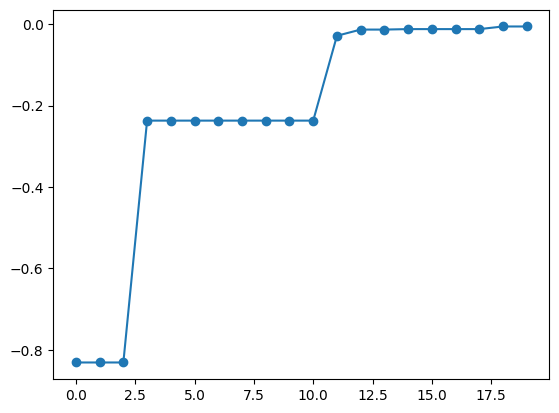

In [7]:
best_fx, best_X = res.export_sequence_best_fx()

plt.plot(best_fx, "o-")

## 獲得関数の最適化アルゴリズム

獲得関数の最適化として、デフォルトではランダムサーチが行われます。つまり、 `nsamples = 1000` 個の候補点をランダムに選び、その中で最も獲得関数が大きい点を選びます。
`nsamples` の値を変更する場合には、 `physbo.search.optimizer.random.Optimizer` を用います。
例えば、 `nsamples = 100` にしたい場合は、次のように `random_optimizer` を作成し、 `bayes_search` 関数の `optimizer` キーワードに渡します。

0001-th step: f(x) = -0.831185 (action=[0.58327442 0.70069668])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0002-th step: f(x) = -5.914186 (action=[1.88281594 1.53921746])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0003-th step: f(x) = -4.352756 (action=[1.63626337 1.29437187])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0004-th step: f(x) = -0.237057 (action=[-0.05316112  0.48397432])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0005-th step: f(x) = -0.488353 (action=[ 0.57404985 -0.39852174])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0006-th step: f(x) = -2.441356 (action=[1.50087645 0.43442582])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0007-th step: f(x) = -3.440784 (action=[-1.57320004 -0.98276443])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0008-th step: f(x) = -3.452

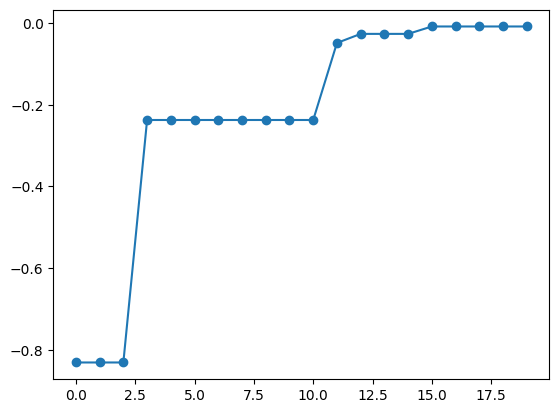

In [8]:
random_optimizer = physbo.search.optimize.random.Optimizer(min_X=min_X, max_X=max_X, nsamples=100)

policy = physbo.search.range.Policy(min_X=min_X, max_X=max_X)
policy.set_seed(seed)
policy.random_search(max_num_probes=10, simulator=simulator)

res = policy.bayes_search(max_num_probes=10, simulator=simulator, score="EI", optimizer=random_optimizer)

best_fx, best_X = res.export_sequence_best_fx()

plt.plot(best_fx, "o-")


`physbo.search.optimize.random.Optimizer` 以外のオプティマイザを使うことで、ランダムサーチ以外の最大化アルゴリズムを利用できます。
PHYSBOでは、ODAT-SEを用いるオプティマイザ `physbo.search.optimize.odatse.Optimizer` を提供しています。このライブラリは

- "exchange": レプリカ交換モンテカルロ法
- "pamc": ポピュレーションアニーリングモンテカルロ法
- "minsearch": Nelder-Mead法
- "mapper": グリッドサーチ
- "bayes": ベイズ最適化

の5つのアルゴリズムを用いて最適化問題を解くことができます。
ODAT-SEのアルゴリズムやハイパーパラメータは、[ODAT-SEの入力ファイル](https://issp-center-dev.github.io/ODAT-SE/manual/main/ja/input.html#algorithm)の `[algorithm]` セクションに相当する辞書を用いて指定します。

`physbo.search.optimize.odatse.default_alg_dict` 関数でこの辞書の雛形ができるので、必要に応じてパラメータを修正します。

In [9]:
import physbo.search.optimize.odatse
odatse_alg_dict = physbo.search.optimize.odatse.default_alg_dict(min_X=min_X, max_X=max_X, algorithm_name="exchange")

# show the default parameters for the exchange algorithm
odatse_alg_dict

{'name': 'exchange',
 'seed': 12345,
 'param': {'min_list': array([-2., -2.]),
  'max_list': array([2., 2.]),
  'step_list': array([0.04, 0.04])},
 'exchange': {'numsteps': 1000,
  'numsteps_exchange': 10,
  'Tmin': 0.1,
  'Tmax': 10.0,
  'Tlogspace': True,
  'nreplica_per_proc': 10}}

`odatse_alg_dict` を `physbo.search.optimize.odatse.Optimizer` に渡してオプティマイザ `odatse_optimizer` を作成します。
これを `random_optimizer` と同様に `bayes_search` 関数の `optimizer` キーワードに渡すことで、ODAT-SEを用いた最適化を行えます。

In [10]:
odatse_optimizer = physbo.search.optimize.odatse.Optimizer(alg_dict=odatse_alg_dict)

policy = physbo.search.range.Policy(min_X=min_X, max_X=max_X)
policy.set_seed(seed)
policy.random_search(max_num_probes=10, simulator=simulator)

res = policy.bayes_search(max_num_probes=10, simulator=simulator, optimizer=odatse_optimizer, score="EI")



0001-th step: f(x) = -0.831185 (action=[0.58327442 0.70069668])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0002-th step: f(x) = -5.914186 (action=[1.88281594 1.53921746])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0003-th step: f(x) = -4.352756 (action=[1.63626337 1.29437187])
   current best f(x) = -0.831185 (best action=[0.58327442 0.70069668]) 

0004-th step: f(x) = -0.237057 (action=[-0.05316112  0.48397432])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0005-th step: f(x) = -0.488353 (action=[ 0.57404985 -0.39852174])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0006-th step: f(x) = -2.441356 (action=[1.50087645 0.43442582])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0007-th step: f(x) = -3.440784 (action=[-1.57320004 -0.98276443])
   current best f(x) = -0.237057 (best action=[-0.05316112  0.48397432]) 

0008-th step: f(x) = -3.452

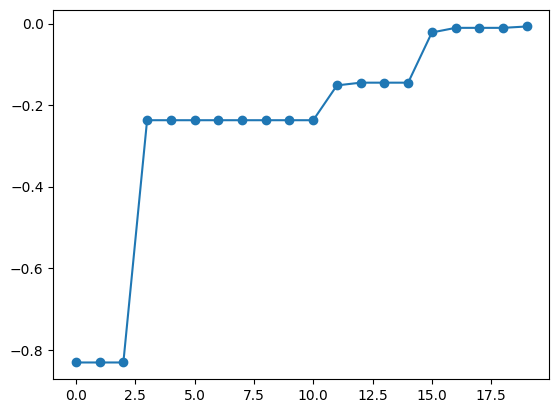

In [11]:
best_fx, best_X = res.export_sequence_best_fx()

plt.plot(best_fx, "o-")